# 1. Import Libraries

Berisi libraries yang digunakan

In [1]:
# import libraries
import pandas as pd
import numpy as np
from scipy import stats

# Untuk kebutuhan visual
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Untuk feature engineering
from sklearn.model_selection import train_test_split

# convert datetime
import datetime as dt

# warnings
import warnings
warnings.filterwarnings('ignore')

# visualisasi
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm

# scaling
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler

# outlier handling
from feature_engine.outliers import Winsorizer

# PCA
from sklearn.decomposition import PCA

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# modeling 
from sklearn.cluster import KMeans

# model saving
import pickle

# 2. Data Loading

Berisi data loading dan informasi data

In [2]:
# Load data
data = pd.read_csv('clean.csv')

In [3]:
# Menampilkan data
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
392727,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
392728,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
392729,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
392730,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [4]:
# informasi dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392732 entries, 0 to 392731
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392732 non-null  int64  
 1   StockCode    392732 non-null  object 
 2   Description  392732 non-null  object 
 3   Quantity     392732 non-null  int64  
 4   InvoiceDate  392732 non-null  object 
 5   UnitPrice    392732 non-null  float64
 6   CustomerID   392732 non-null  int64  
 7   Country      392732 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 24.0+ MB


Data yang ditampilkan memiliki 8 kolom dan 541,908 baris, yaitu 1 kolom dengan tipe data datetime64, 2 kolom dengan tipe data float64, 1 kolom dengan tipe data int64, dan 4 kolom dengan tipe object.

| Column Name | Data Type | Description |
|---|---|---|
| `InvoiceNo` | object | a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation |
| `StockCode` | object | a 5-digit integral number uniquely assigned to each distinct product |
| `Description` | object | product name |
| `Quantity` | int64 | the quantities of each product (item) per transaction |
| `InvoiceDate` | datetime64[ns] | the day and time when each transaction was generated |
| `UnitPrice` | float64 | product price per unit |
| `CustomerID` | float64 | a 5-digit integral number uniquely assigned to each customer |
| `Country` | object | the name of the country where each customer resides |

# 3. Exploratory Data Analysis (EDA)

Berisi exploratory data sederhana menggunakan data raw

## 3.1 Analisis Waktu Pembelian

Menentukan jam atau hari dalam seminggu ketika pelanggan paling sering melakukan pembelian, untuk mengoptimalkan waktu pengiriman email marketing atau promosi.

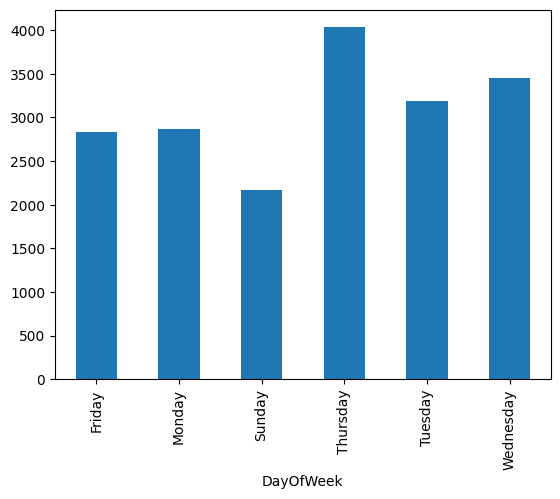

In [5]:
# Convert InvoiceDate to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Extract hour and day of the week from InvoiceDate
data['Hour'] = data['InvoiceDate'].dt.hour
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()

# Calculate the number of unique invoices per hour and day
hourly_sales = data.groupby('Hour')['InvoiceNo'].nunique().plot(kind='bar')
daily_sales = data.groupby('DayOfWeek')['InvoiceNo'].nunique().plot(kind='bar')


Text(0.5, 1.0, 'Jumlah Pembelian per Hari')

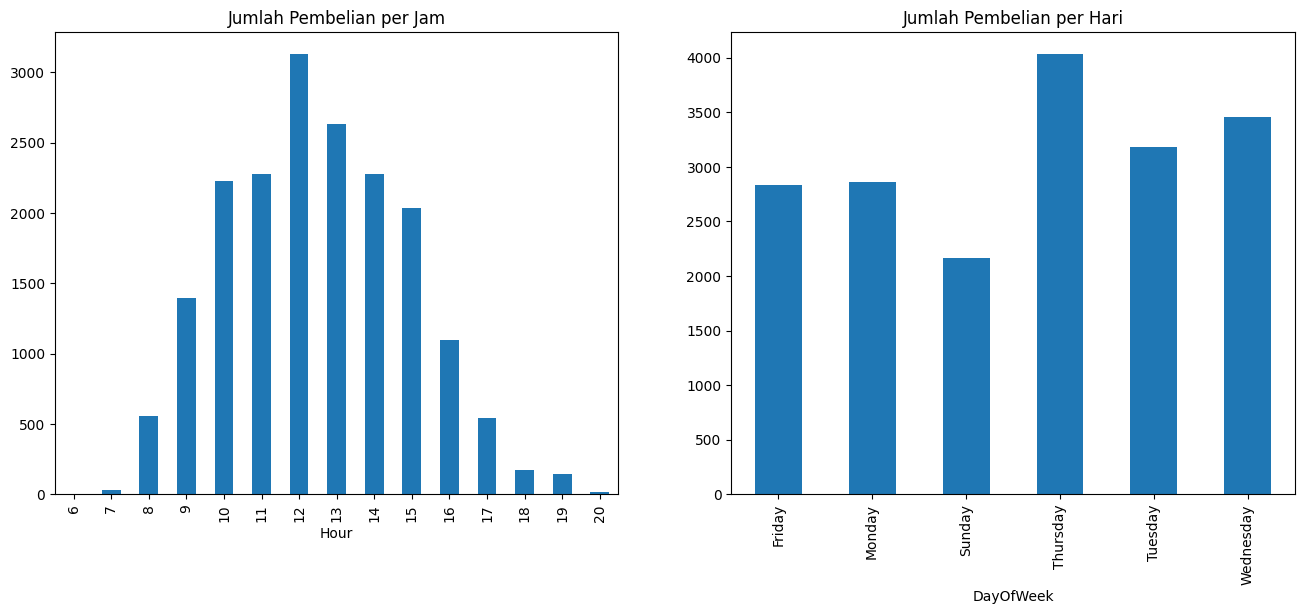

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
data.groupby('Hour')['InvoiceNo'].nunique().plot(kind='bar', ax=ax[0])
ax[0].set_title('Jumlah Pembelian per Jam')
data.groupby('DayOfWeek')['InvoiceNo'].nunique().plot(kind='bar', ax=ax[1])
ax[1].set_title('Jumlah Pembelian per Hari')

## 3.2 Analisis Retensi Pelanggan

Menentukan seberapa sering pelanggan kembali untuk melakukan pembelian lain setelah pembelian pertama mereka, untuk mengukur loyalitas pelanggan

<Axes: ylabel='Frequency'>

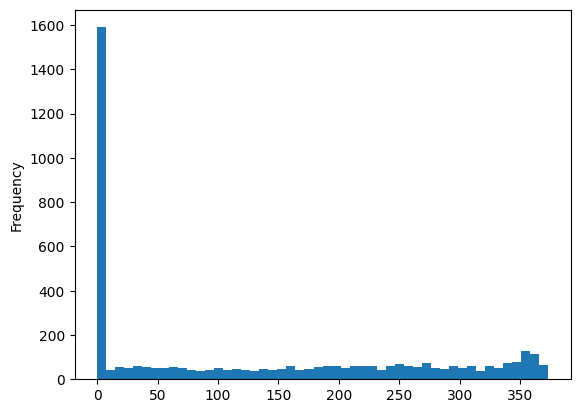

In [7]:
# Membuat kolom yang menunjukkan waktu pembelian pertama
data['FirstPurchase'] = data.groupby('CustomerID')['InvoiceDate'].transform('min')

# Menghitung selisih antara setiap pembelian dengan pembelian pertama
data['DaysSinceFirstPurchase'] = (data['InvoiceDate'] - data['FirstPurchase']).dt.days

# Analisis distribusi DaysSinceFirstPurchase untuk melihat pola retensi
retention_analysis = data.groupby('CustomerID')['DaysSinceFirstPurchase'].max().reset_index()
retention_analysis['DaysSinceFirstPurchase'].plot(kind='hist', bins=50)

Text(0.5, 1.0, 'Distribusi Hari Sejak Pembelian Pertama')

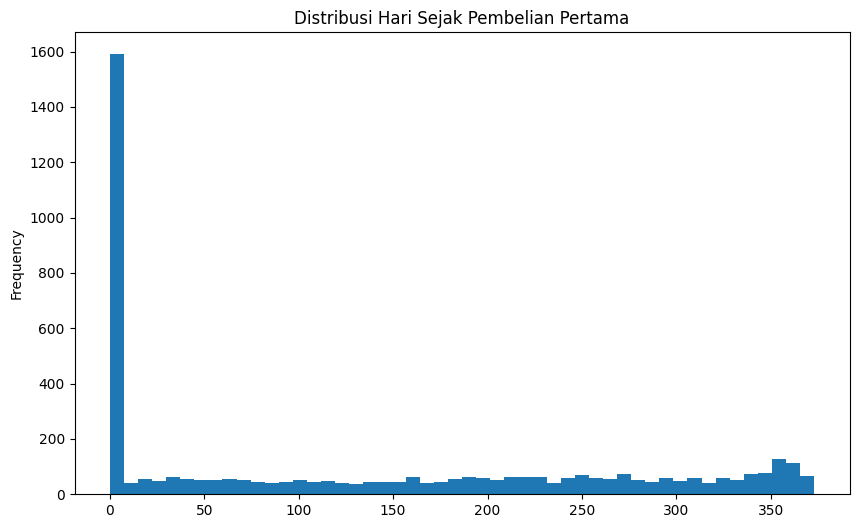

In [8]:
retention_analysis['DaysSinceFirstPurchase'].plot(kind='hist', bins=50, figsize=(10, 6))
plt.title('Distribusi Hari Sejak Pembelian Pertama')

# 4. Pra-processing Data

### A. Missing Values

In [9]:
# cek missing value
data.isnull().sum()

InvoiceNo                 0
StockCode                 0
Description               0
Quantity                  0
InvoiceDate               0
UnitPrice                 0
CustomerID                0
Country                   0
Hour                      0
DayOfWeek                 0
FirstPurchase             0
DaysSinceFirstPurchase    0
dtype: int64

In [10]:
# handling missing values
data = data.dropna()

### B. Data Duplicate 

In [11]:
# cek data duplicate
data.duplicated().sum()

0

In [12]:
# Dictionary untuk menyimpan hasil
columns_with_duplicates = {}

# Iterasi melalui setiap kolom untuk mengecek duplikat
for column in data.columns:
    if data[column].duplicated().any():  # Cek jika ada duplikat di kolom tersebut
        columns_with_duplicates[column] = True
    else:
        columns_with_duplicates[column] = False

# Menampilkan kolom yang memiliki data duplikat
for column, has_duplicates in columns_with_duplicates.items():
    if has_duplicates:
        print(f"Kolom '{column}' memiliki data duplikat.")
    else:
        print(f"Kolom '{column}' tidak memiliki data duplikat.")

Kolom 'InvoiceNo' memiliki data duplikat.
Kolom 'StockCode' memiliki data duplikat.
Kolom 'Description' memiliki data duplikat.
Kolom 'Quantity' memiliki data duplikat.
Kolom 'InvoiceDate' memiliki data duplikat.
Kolom 'UnitPrice' memiliki data duplikat.
Kolom 'CustomerID' memiliki data duplikat.
Kolom 'Country' memiliki data duplikat.
Kolom 'Hour' memiliki data duplikat.
Kolom 'DayOfWeek' memiliki data duplikat.
Kolom 'FirstPurchase' memiliki data duplikat.
Kolom 'DaysSinceFirstPurchase' memiliki data duplikat.


In [13]:
# Handling data duplicate
data.drop_duplicates()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Hour,DayOfWeek,FirstPurchase,DaysSinceFirstPurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,8,Wednesday,2010-12-01 08:26:00,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,2010-12-01 08:26:00,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,8,Wednesday,2010-12-01 08:26:00,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,2010-12-01 08:26:00,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,2010-12-01 08:26:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
392727,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,12,Friday,2011-08-18 15:44:00,112
392728,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12,Friday,2011-08-18 15:44:00,112
392729,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,12,Friday,2011-08-18 15:44:00,112
392730,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,12,Friday,2011-08-18 15:44:00,112


### C. Menghapus data pada kolom 'Quantity' yang bernilai (-)

In [14]:
minus = data[data['Quantity'] < 0]
minus

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Hour,DayOfWeek,FirstPurchase,DaysSinceFirstPurchase


In [15]:
data = data.drop(data[data['Quantity'] < 0].index)

In [16]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

Data telah bersih dari:
- null
- dupicates 
- data dengan Quantity (-) atau data cancellation transaksi, data ini kita drop dikarenakan kita ingin membuat segmentasi customer yang dimana data ini tidak relevant dengan objective yang ingin diambil

# 5. RFM

## 5.1 Feature Engineering

### A. Menambahkan kolom


Analisis RFM sering digunakan untuk segmentasi dan penargetan pelanggan dalam strategi pemasaran.

Sebelum analisis RFM perlu membuat kolom baru yaitu 'Total Price' untuk mengetahui total biaya dari setiap CustomerID/InvoiceNo, kolom ini nantinya akan berfungsi pada RFM segmentasi

In [17]:
# Menambahkan kolom baru
data['TotalPrice'] = data['UnitPrice']*data['Quantity']
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Hour,DayOfWeek,FirstPurchase,DaysSinceFirstPurchase,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,8,Wednesday,2010-12-01 08:26:00,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,2010-12-01 08:26:00,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,8,Wednesday,2010-12-01 08:26:00,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,2010-12-01 08:26:00,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,2010-12-01 08:26:00,0,20.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
392727,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,12,Friday,2011-08-18 15:44:00,112,10.20
392728,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12,Friday,2011-08-18 15:44:00,112,12.60
392729,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,12,Friday,2011-08-18 15:44:00,112,16.60
392730,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,12,Friday,2011-08-18 15:44:00,112,16.60


In [18]:
# Menampilkan transaksi pertama dan terakhir
print(data['InvoiceDate'].min(), data['InvoiceDate'].max())
now = dt.datetime(2011,12,10) # Dianggap tanggal hari ini

2010-12-01 08:26:00 2011-12-09 12:50:00


Dari data di atas diketahui waktu transaksi yaitu :
- Transaksi Pertama 01 Dec 2010
- Transaksi terakhir 09 Dec 2011

Dianggap tanggal hari ini ialah tanggal 10 Dec 2011, sehari setelah transaksi terakhir

### B. Pengelompokan dengan RFM (Recency, Frequency, dan Monetary)

In [19]:
rfmTable = data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (now - x.max()).days, # Recency
                                        'CustomerID': lambda x: len(x), # Frequency
                                        'TotalPrice': lambda x: x.sum()}) # Monetary Value


rfmTable.rename(columns={'InvoiceDate': 'recency',
                         'CustomerID': 'frequency',
                         'TotalPrice': 'monetary_value'}, inplace=True)

Fungsi diatas RFM (Recency, Frequency, Monetary) untuk segmentasi pelanggan. 

Awalnya data dikelompokkan berdasarkan CustomerID

Untuk Recency :
- *'InvoiceDate': lambda x: (now - x.max()).days* untuk menghitung recency untuk setiap pelanggan dengan mencari jumlah hari antara tanggal faktur terbaru dan tanggal saat ini (sekarang).

Untuk Frekuensi :
- *'CustomerID': lambda x: len(x)* untuk menghitung Frequency transaksi untuk setiap pelanggan, yaitu berapa banyak faktur yang mereka miliki.

Untuk Monetary
- *'TotalPrice': lambda x: x.sum()* untuk menghitung total nilai moneter transaksi untuk setiap pelanggan.

kemudian rfmTable disimpan dengan mengganti nama kolom DataFrame yang dihasilkan agar lebih mudah dibaca, tabel RFM (rfmTable) dengan tiga kolom: 'recency', 'frequency', dan 'monetary_value'. 



In [20]:
# Menampilkan 5 data teratas
rfmTable.head()

,recency,frequency,monetary_value
CustomerID,,,
12346,325,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,18,73,1757.55
12350,310,17,334.40


Hasilnya berupa kolom yang menampilkan recency, frequency, dan monetary value

In [ ]:
# menampilkan info rfmTable
rfmTable.info()

In [21]:
# Menyimpan data
rfmTable.to_csv('rfm.csv', index=False)

menyimpan rfmTable kedalam csv, data ini akan dibutuhkan untuk pemodelan clustering selanjutnya

In [22]:
data[data['CustomerID'] == 12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Hour,DayOfWeek,FirstPurchase,DaysSinceFirstPurchase,TotalPrice
36543,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,10,Tuesday,2011-01-18 10:01:00,0,77183.6


In [23]:
quartiles = rfmTable.quantile(q=[0.25,0.50,0.75])
print(quartiles, type(quartiles))

      recency  frequency  monetary_value
0.25     17.0       17.0         306.455
0.50     50.0       41.0         668.560
0.75    141.5       98.0        1660.315 <class 'pandas.core.frame.DataFrame'>


Untuk melakukan analisis RFM, pelanggan dibagi menjadi empat kelompok yang sama menurut distribusi nilai pengkategorian R,F, dan M .

Sehingga untuk Recency terdapat 4 kelompok, Frequency terdapat 4 kelompok, dan Monetary terdapat 4 kelompok, sehingga hasilnya akan menghasilkan 64 (4x4x4) segmen pelanggan yang berbeda (jumlah yang tidak terlalu banyak dan dapat dikelola)

In [24]:
quartiles=quartiles.to_dict()
quartiles

{'recency': {0.25: 17.0, 0.5: 50.0, 0.75: 141.5},
 'frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 98.0},
 'monetary_value': {0.25: 306.45500000000004,
  0.5: 668.5600000000002,
  0.75: 1660.315}}

### C. RClass (Recency) dan FMClass (Frequency & Monetary)

Untuk menetapkan kelas kepada pelanggan berdasarkan kuartil recency (terkini), frequency (frekuensi), dan nilai monetary (moneter).

In [25]:
# RClass untuk Recency

def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1 # most recent
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

## FMClass untuk Frequency dan Monetary value

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1 # most frequent and most monetary


Fungsi diatas kita mencoba untuk mengkategorikan 

    - Group Customer yang membeli paling terakhir/recently R = 1
    - Group Customer yang membeli paling sering/frequently F = 1
    - Group Customer yang membeli paling banyak/monetary M = 1


- Fungsi RClass (Recency): Membandingkan nilai recency (x) dengan nilai kuartil dan menetapkan kelas (1, 2, 3, atau 4) berdasarkan di mana nilai kekinian berada dalam kuartil. Membutuhkan tiga parameter:
    - x : Nilai recency untuk pelanggan tertentu.
    - p: Key ('recency') yang menunjukkan kuartil mana yang akan digunakan.
    - d : Dictionary yang berisi nilai kuartil.

- Fungsi FMClass (Frequency dan Monetary): Menetapkan kelas (1, 2, 3, atau 4) berdasarkan Frequency atau Monetary yang termasuk dalam kuartil. membutuhkan tiga parameter:
    - x: Frequency atau nilai Monetary untuk pelanggan tertentu.
    - p: Key ('Frequency' atau 'monetary') yang menunjukkan kuartil mana yang akan digunakan.
    - d : Dictionary yang berisi nilai kuartil.

### D. Segmentasi Recency, Frequency, dan Monetary

In [26]:
# mengelompokkan pelanggan ke dalam kuartil berdasarkan Recency, Frequency, dan Monetary
rfmSeg = rfmTable
rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))

Membuat tiga kolom tambahan ('R_Quartile', 'F_Quartile', dan 'M_Quartile') yang masing-masing berisi segmen berbasis kuartil untuk recency, frequency, dan monetary value untuk analisis lebih lanjut dan segmentasi pelanggan.

In [27]:
# Menggabungkan nilai kuartil dari Recency, Frequency, dan Monetary
rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) \
                            + rfmSeg.F_Quartile.map(str) \
                            + rfmSeg.M_Quartile.map(str)

Membuat kolom baru yang menampilkan penjumlahan dari tiap kolom R_Quartile, F_Quartile, dan M_Quartile

In [28]:
# Menampilkan 5 data teratas
rfmSeg.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerID,,,,,,,
12346,325,1,77183.60,4,4,1,441
12347,2,182,4310.00,1,1,1,111
12348,75,31,1797.24,3,3,1,331
12349,18,73,1757.55,2,2,1,221
12350,310,17,334.40,4,4,3,443


menampilkan hasil datanya

In [29]:
#  Mengurutkan data berdasarkan kelas RFM dan Monetary Value
rfmSeg.sort_values(by=['RFMClass', 'monetary_value'], ascending=[True, False])

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerID,,,,,,,
14646,1,2080,280206.02,1,1,1,111
18102,0,431,259657.30,1,1,1,111
17450,8,336,194390.79,1,1,1,111
14911,1,5672,143711.17,1,1,1,111
14156,9,1395,117210.08,1,1,1,111
...,...,...,...,...,...,...,...
17102,261,1,25.50,4,4,4,444
15823,372,1,15.00,4,4,4,444
17763,263,1,15.00,4,4,4,444


Mengurutkan data berdasarkan RFM Class terendah yaitu 1 dan di-groupkan berdasarkan monetary valuenya, dimana terlihat hasil monetary value nilainya dari besar ke kecil

In [30]:
# Menghitung rata-rata Monetary value dari setiap kelompok RFMClass
rfmSeg.groupby('RFMClass').agg('monetary_value').mean()

RFMClass
111     9393.177652
112     1170.045632
113      541.906429
114      289.180000
121     4361.836420
           ...     
434      199.909307
441    17815.672000
442      961.328333
443      392.449725
444      157.415433
Name: monetary_value, Length: 61, dtype: float64

Sesuai dengan RFM Class nya, mencari rata - rata monetary value dari tiap RFM class

In [31]:
# Menghitung skor total RFM dengan menjumlahkan nilai quartile dari Recency, Frequency, dan Monetary pada setiap pelanggan
rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']

# Menampilkan data
print(rfmSeg.head())

            recency  frequency  monetary_value  R_Quartile  F_Quartile  \
CustomerID                                                               
12346           325          1        77183.60           4           4   
12347             2        182         4310.00           1           1   
12348            75         31         1797.24           3           3   
12349            18         73         1757.55           2           2   
12350           310         17          334.40           4           4   

            M_Quartile RFMClass  Total Score  
CustomerID                                    
12346                1      441            9  
12347                1      111            3  
12348                1      331            7  
12349                1      221            5  
12350                3      443           11  


Total Score merupakan jumlah dari masing R_Quartile, F_Quartile, dan M_Quartile

In [32]:
print("Best Customers: ",len(rfmSeg[rfmSeg['RFMClass']=='111'])) # Customer yang sering transaksi, paling sering, & paling banyak
print('Loyal Customers: ',len(rfmSeg[rfmSeg['F_Quartile']==1])) # Customer dengan pembelanjaan paling sering
print("Big Spenders: ",len(rfmSeg[rfmSeg['M_Quartile']==1])) # Customer dengan pembelian paling banyak
print('Almost Lost: ',len(rfmSeg[rfmSeg['RFMClass']=='311'])) # Customer yang pernah transaksi, paling sering, & total banyak
print('Lost Customers: ',len(rfmSeg[rfmSeg['RFMClass']=='411'])) # Customer yang pernah transaksi, paling sering, & total banyak
print('Lost Cheap Customers: ',len(rfmSeg[rfmSeg['RFMClass']=='444'])) # Customer yang pernah transaksi, paling jarang, & total sedikit

Best Customers:  443
Loyal Customers:  1080
Big Spenders:  1085
Lost Customers:  22
Lost Cheap Customers:  381



Best Customers merujuk ke RFM segment 1-1-1

Fungsi diatas bertujuan untuk menghitung jumlah pelanggan berdasarkan segmentasi RFM (Recency, Frequency, Monetary) untuk melihat pelanggan terbaik, pelanggan setia, pelanggan yang pengeluarannya besar, pelanggan yang hampir hilang, dan pelanggan yang sudah hilang.

<Axes: xlabel='Total Score'>

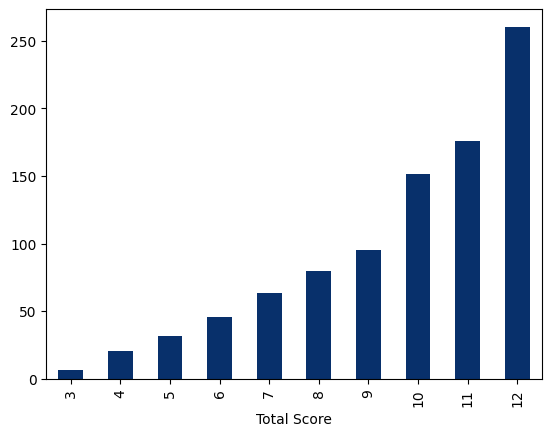

In [33]:
# Menghitung rata-rata Recency berdasarkan Total Score
rfmSeg.groupby('Total Score').agg('recency').mean().plot(kind='bar', colormap='Blues_r')

dari graph diatas memvisualisasikan nilai recency rata-rata untuk setiap grup, seperti contoh untuk skor total dalam RFM (rfmSeg, Total Score 12, R=4, F=4, dan M=4) memiliki rata - rata recency yang lebih tinggi yaitu Customer yang pernah transaksi, paling jarang, & total sedikit

<Axes: xlabel='Total Score'>

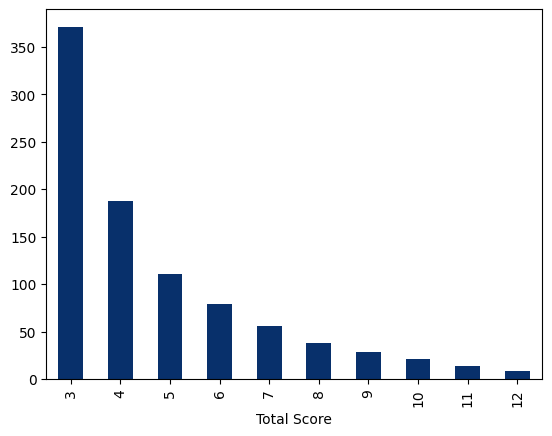

In [34]:
# Menghitung rata-rata Frequency berdasarkan Total Score
rfmSeg.groupby('Total Score').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')

dari graph diatas memvisualisasikan nilai frequency rata-rata untuk setiap grup, seperti contoh untuk skor total dalam RFM (rfmSeg, Total Score 3, R=1, F=1, dan M=1) memiliki rata - rata frequency yang lebih tinggi yaitu Customer yang sering transaksi, paling sering, & paling banyak

<Axes: xlabel='Total Score'>

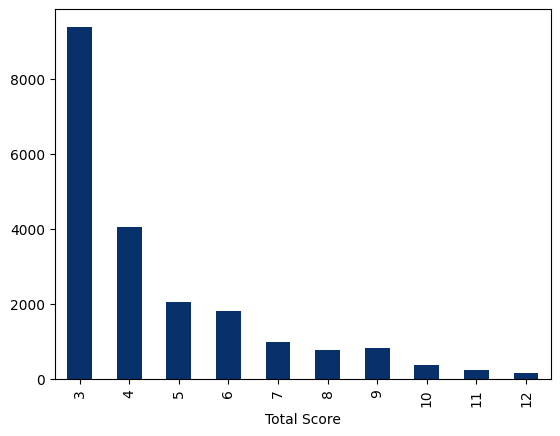

In [35]:
# Menghitung rata-rata Monetary value berdasarkan Total Score
rfmSeg.groupby('Total Score').agg('monetary_value').mean().plot(kind='bar', colormap='Blues_r')

dari graph diatas memvisualisasikan nilai monetary value rata-rata untuk setiap grup, seperti contoh untuk skor total dalam RFM (rfmSeg, Total Score 3, R=1, F=1, dan M=1) memiliki rata - rata monetary value yang lebih tinggi yaitu Customer yang sering transaksi, paling sering, & paling banyak

# 6. Clustering

## 6.1. Data Loading

In [36]:
# data loading
rfm = pd.read_csv('rfm.csv')

# menampilkan data
rfm

,recency,frequency,monetary_value
0,325,1,77183.60
1,2,182,4310.00
2,75,31,1797.24
3,18,73,1757.55
4,310,17,334.40
...,...,...,...
4334,277,10,180.60
4335,180,7,80.82
4336,7,12,178.05
4337,3,721,2045.53


In [37]:
# menampilkan informasi data
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         4339 non-null   int64  
 1   frequency       4339 non-null   int64  
 2   monetary_value  4339 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 101.8 KB


## 6.2 Feature Engineering

### A. Outlier Handling

In [38]:
# melihat distribusi data setiap kolom numerik
listSkew = []
for col in rfm:
  listSkew.append([col, rfm[col].mean(), rfm[col].median(), 
                   rfm[col].mode()[0], rfm[col].skew(),rfm[col].kurtosis()])

pd.DataFrame(columns=['column name', 'mean', 'median','mode','skew','kurtosis'], data=listSkew)

,column name,mean,median,mode,skew,kurtosis
0,recency,92.041484,50.00,1.00,1.246137,0.431242
1,frequency,90.512100,41.00,10.00,18.043619,478.859604
2,monetary_value,2048.215924,668.56,76.32,19.341403,478.787722


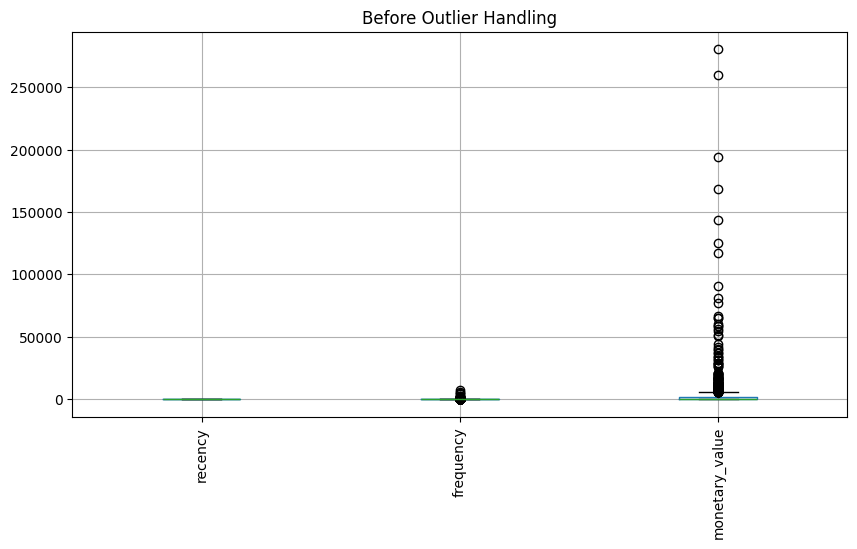

In [39]:
# boxplot untuk melihat outlier
plt.figure(figsize=(10,5))
rfm.boxplot(rot=90, whis=3)
plt.title('Before Outlier Handling')
plt.show()

In [40]:
# handling outlier
wz = Winsorizer(capping_method='iqr', tail='both', fold=3, variables=['recency', 'frequency', 'monetary_value'])
rfm = wz.fit_transform(rfm)

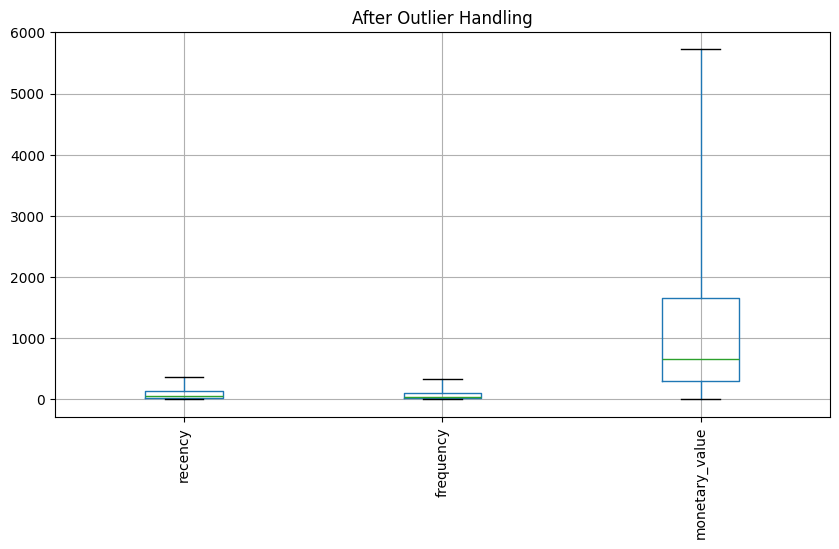

In [41]:
# visualisasi setelah dilakukan handling outlier
plt.figure(figsize=(10,5))
rfm.boxplot(rot=90, whis=3)
plt.title('After Outlier Handling')
plt.show()

### B. Scaling

In [42]:
# scalling data
scaler = StandardScaler()
scaler.fit(rfm)

rfm_scaled = scaler.transform(rfm)

# menampilkan data
rfm_scaled

array([[ 2.32967293, -0.85755962,  2.93182131],
       [-0.90044877,  1.22538866,  1.99550707],
       [-0.17042126, -0.51231957,  0.32914169],
       ...,
       [-0.85044688, -0.7309716 , -0.74464258],
       [-0.89044839,  3.0551609 ,  0.49379803],
       [-0.5004337 , -0.06350751,  0.35569467]])

In [43]:
# ubah data scaling menjadi dataframe
rfm_scaled = pd.DataFrame(rfm_scaled,columns=rfm.columns)

rfm_scaled

,recency,frequency,monetary_value
0,2.329673,-0.857560,2.931821
1,-0.900449,1.225389,1.995507
2,-0.170421,-0.512320,0.329142
3,-0.740443,-0.028984,0.302821
4,2.179667,-0.673432,-0.640957
...,...,...,...
4334,1.849655,-0.753988,-0.742952
4335,0.879618,-0.788512,-0.809122
4336,-0.850447,-0.730972,-0.744643
4337,-0.890448,3.055161,0.493798


### C. PCA

In [44]:
# inisialisasi PCA
pca = PCA()
pca.fit(rfm_scaled)

PCA()

Text(0, 0.5, 'Explained Variance Ratio - Cummulative')

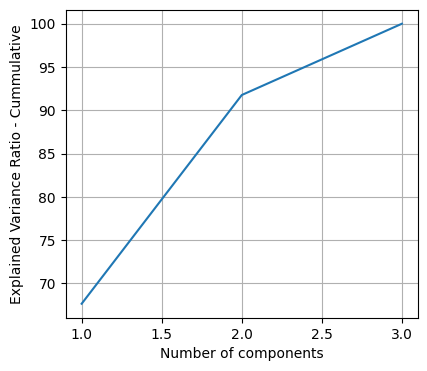

In [45]:
# Plot the Cummulative of Explained Variance Ratio
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, 4), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

Text(0, 0.5, 'Eigenvalues')

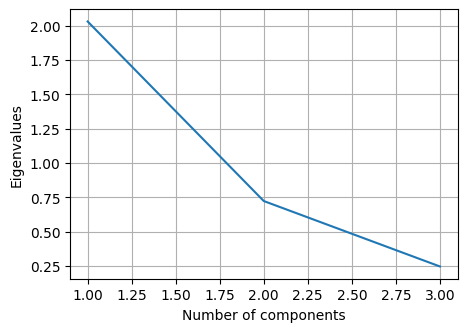

In [46]:
# Plot the Eigenvalues
plt.figure(figsize=[5, 3.5])
plt.grid()
plt.plot(range(1, 4), pca.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

In [47]:
# Mengambil jumlah kolom dengan 95% informasi
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
num_features

3

> Based on the analysis, it is stated that to obtain 95% of the information in this data, we need 3 features. Therefore, PCA will be performed according to the obtained value. However, PCA does not actually have to be performed on this data because the number of features in this data is still relatively low.

In [48]:
# Train dengan df scaled
pca = PCA(n_components=0.95)
pca.fit(rfm_scaled)

rfm_scaled_pca = pca.transform(rfm_scaled)

# menampilkan data
rfm_scaled_pca

array([[ 0.21939364,  2.81195719,  2.60827986],
       [ 2.43433451,  0.2638704 ,  0.54664588],
       [-0.038624  , -0.1954319 ,  0.60013629],
       ...,
       [-0.53447658, -1.23530917,  0.02044524],
       [ 2.64409951,  0.31849008, -1.81053716],
       [ 0.41279469, -0.34121373,  0.30685424]])

## 6.3 Cluster Analysis

### A. Elbow Method

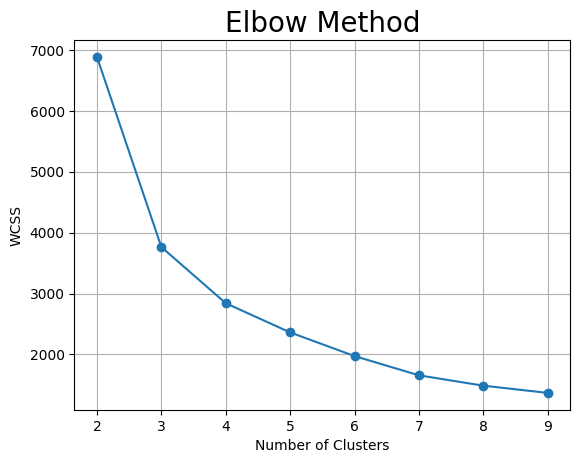

In [49]:
wcss = []
random_state = 69
max_cluster = 9
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    km.fit(rfm_scaled)
    wcss.append(km.inertia_)

# Menampilkan visualisasi
plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

> If we look at the visualization above, the number 3 or 4 can be chosen for cluster division. To ensure this, next, a search for the silhouette score will be conducted, as well as the creation of a silhouette plot, and a cluster visualization plot.

### B. Silhouette Score

In [50]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score,silhouette_samples

def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.5231975755585156
For n_clusters = 3 The average silhouette_score is : 0.5059010895268563
For n_clusters = 4 The average silhouette_score is : 0.4658437142175485
For n_clusters = 5 The average silhouette_score is : 0.4498363472317305
For n_clusters = 6 The average silhouette_score is : 0.4138062400748636
For n_clusters = 7 The average silhouette_score is : 0.41212763723982315
For n_clusters = 8 The average silhouette_score is : 0.392341284487821


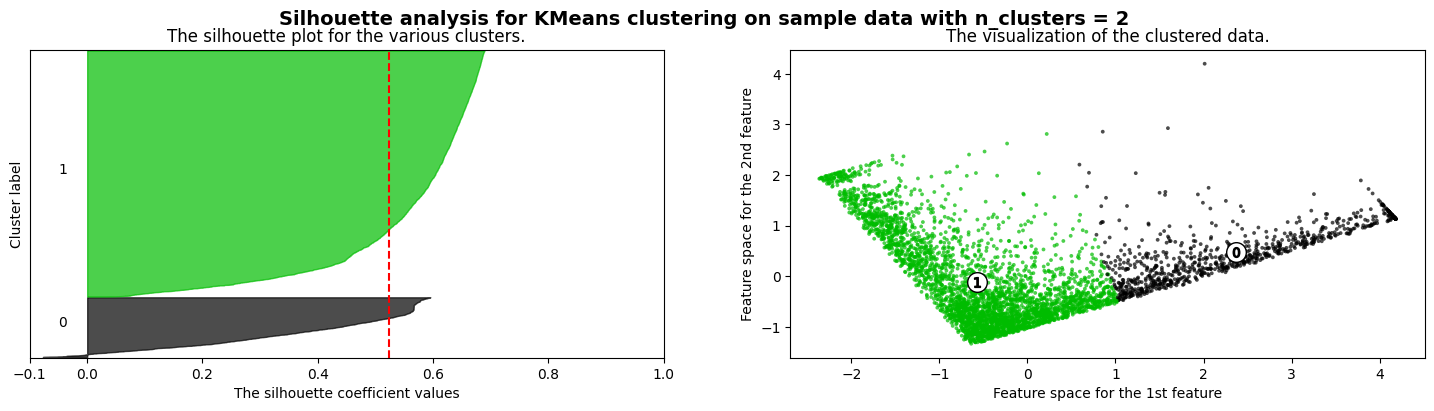

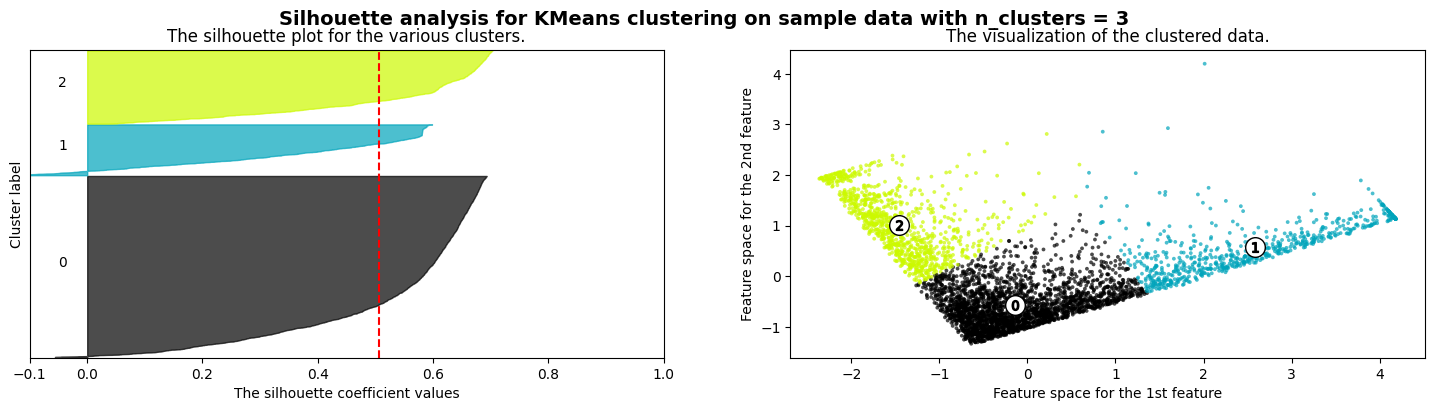

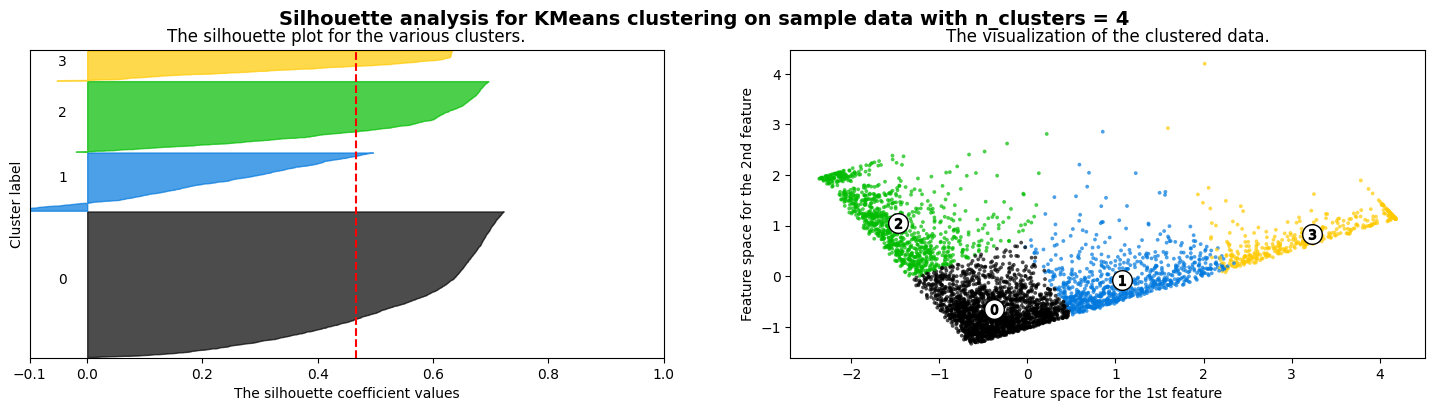

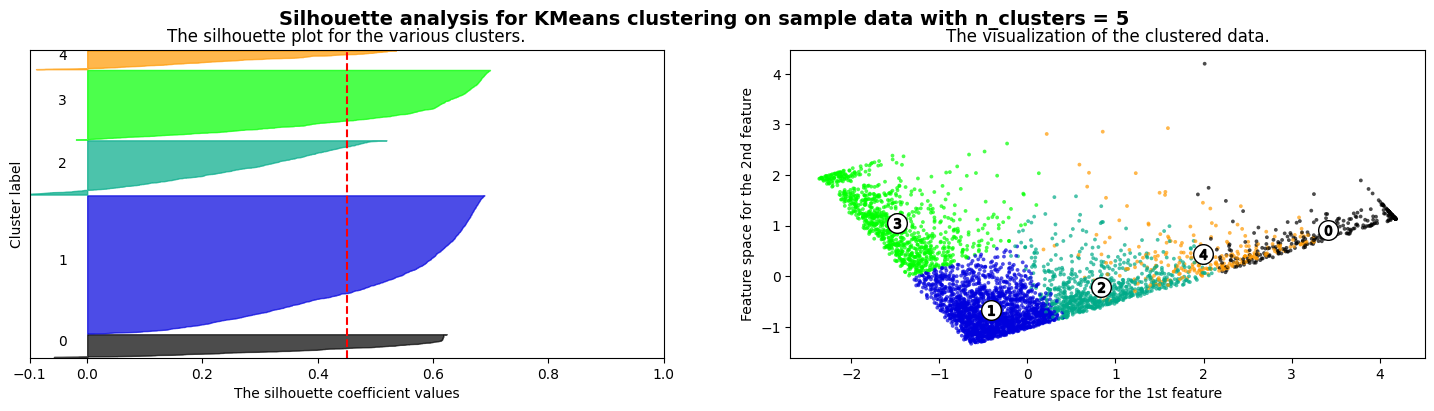

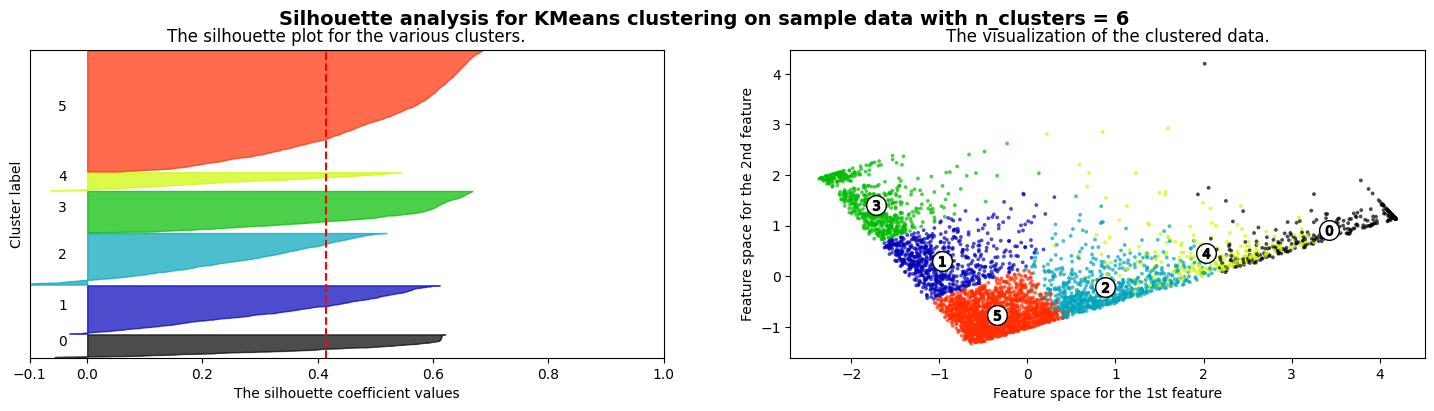

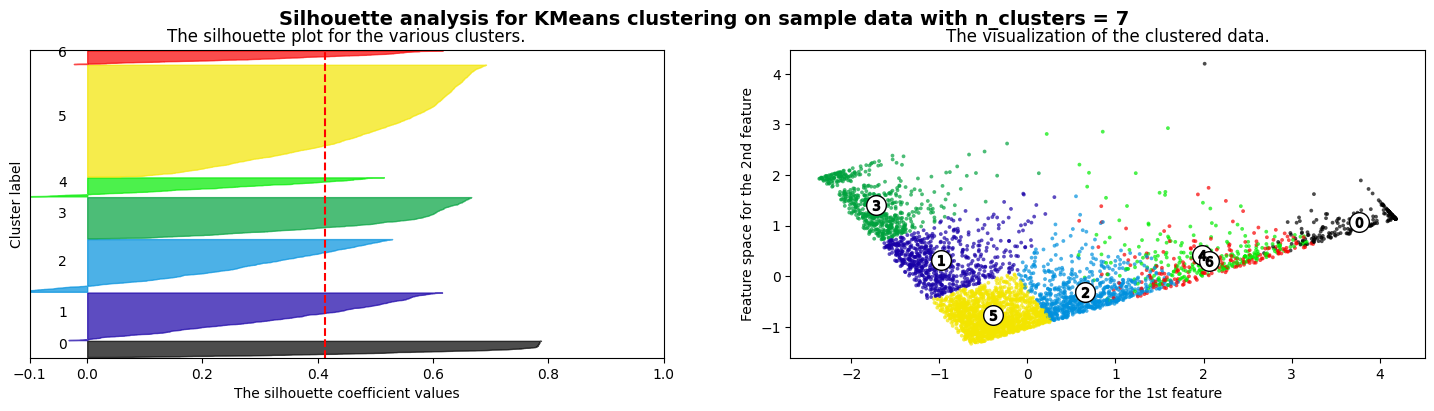

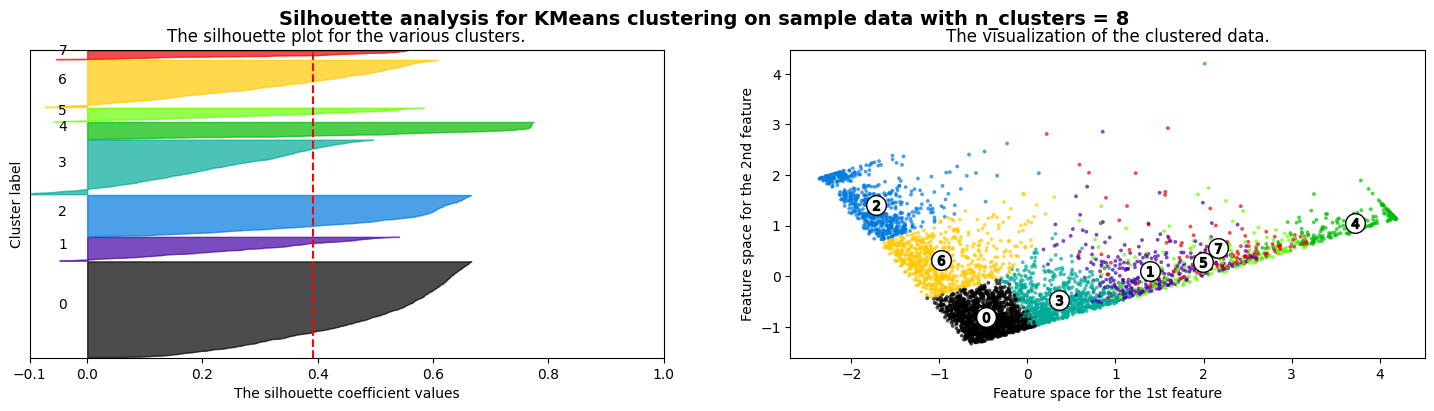

In [51]:
# menampilkan visualisasi silhouette score
plot_silhouette(range(2, max_cluster), rfm_scaled_pca, random_state)

>Based on the Silhouette Score (0.505), even though it's not the best, 3 clusters have the best cluster visualization. Although there is a slight leakage of clusters seen in the silhouette plot. If we look through the Elbow Method, Silhouette Plot, Silhouette Score, and Cluster Visualization, the data can be divided into 3 clusters.

## 6.4 Pipeline

In [52]:
from sklearn.cluster import KMeans

scaler = RobustScaler()
pca = PCA(n_components=0.95)
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)

ct = ColumnTransformer([
    ('scaler', scaler, list(rfm.columns))
])

model = Pipeline([
    ('preprocessing', ct),
    ('pca', pca),
    ('model', km),
    
])

pred = model.fit_predict(rfm)


## 6.5 Clustering Analysis (EDA II)

In [53]:
# pembuatan kolom cluster
rfm['cluster'] = pred
rfm.sample(7)

,recency,frequency,monetary_value,cluster
546,373,14,205.86,2
4045,12,53,156.34,1
2039,60,102,1471.00,1
2604,92,18,379.35,1
980,149,83,299.05,1
4015,81,51,901.20,1
1262,106,10,725.64,1


In [54]:
# membuat dataframe berisi data masing2 cluster
cluster0 = rfm[rfm['cluster']==0]
cluster1 = rfm[rfm['cluster']==1]
cluster2 = rfm[rfm['cluster']==2]

### Find Average Value in Recency for each Cluster

<Axes: ylabel='cluster'>

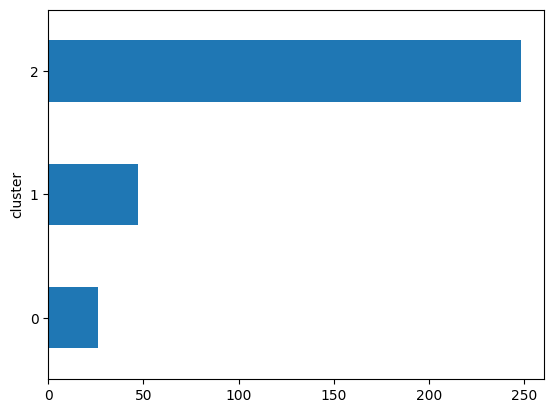

In [67]:
rfm.groupby('cluster')['recency'].mean().plot(kind='barh')

Insight: Recency mengalami kebocoran data dengan cluster 1 dan 0 memiliki minimal Recency yang sama, maka recency tidak bisa menjadi konsiderasi atas cluster.

### Find Max Values of Recency for each cluster

In [66]:
rfm.groupby('cluster')['recency'].max()

cluster
0    372
1    194
2    373
Name: recency, dtype: int64

### Find Max Values of Frequency For Each Cluster

<Axes: ylabel='cluster'>

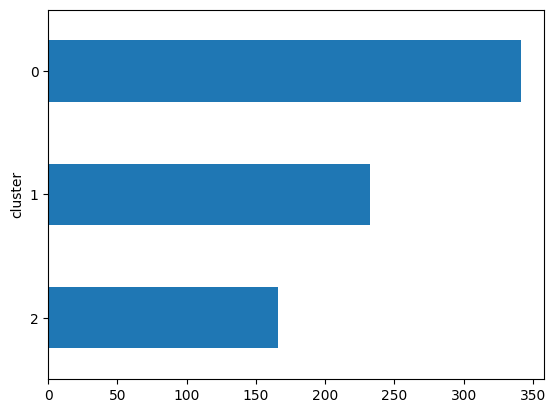

In [56]:
rfm.groupby('cluster')['frequency'].max().sort_values().plot(kind='barh')

Insight: Cluster 0 Memiliki Frekuensi Maximum Tertinggi diikuti dengan Cluster 1 dan Cluster 2

### Find Min Value of Frequency for Each Cluster

<Axes: ylabel='cluster'>

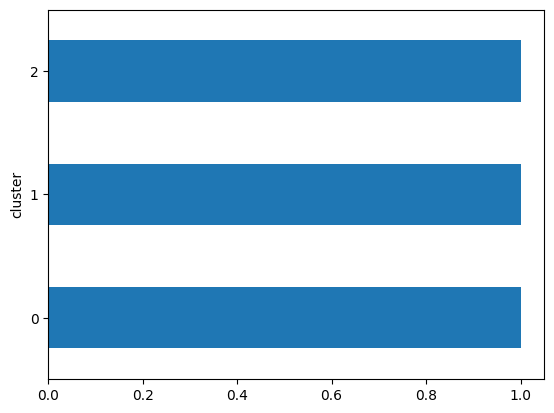

In [57]:
rfm.groupby('cluster')['frequency'].min().sort_values().plot(kind='barh')

Insight: Frequency Minimal dalam setiap Cluster sama.

### Find Average of Frequency for Each Cluster

<Axes: ylabel='cluster'>

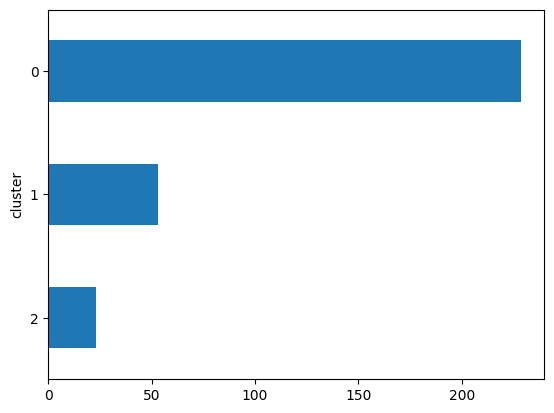

In [65]:
rfm.groupby('cluster')['frequency'].mean().sort_values().plot(kind='barh')

Insight: Untuk Keseluruhan, Cluster 0 Memiliki Tingkat Frekuensi Tertinggi Diikuti Dengan Cluster 1 dan Cluster 2.

### Find Average of Monetary Value for Each Cluster

<Axes: ylabel='cluster'>

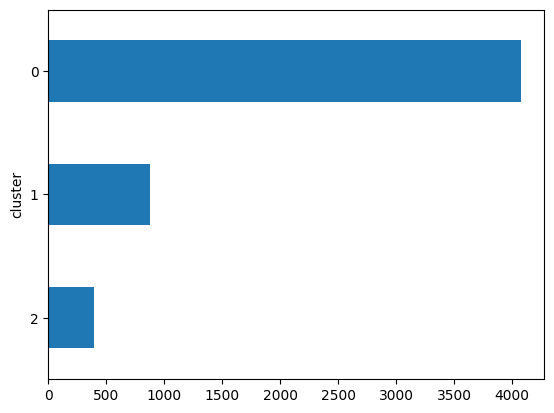

In [58]:
rfm.groupby('cluster')['monetary_value'].mean().sort_values().plot(kind='barh')

Insight: Cluster 0 adalah Cluster yang memiliki rata-rata monetary value tertinggi dibanding cluster 1 dan cluster 2

### See Value Counts of Cluster from inside table

<Axes: ylabel='cluster'>

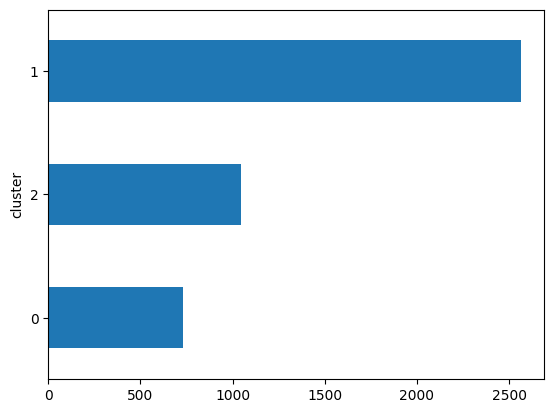

In [59]:
rfm['cluster'].value_counts().sort_values().plot(kind='barh')

Insight: Cluster 1 adalah Cluster yang paling banyak dipanggil diikuti cluster 2 dan cluster 0

### A. Cluster Visualization

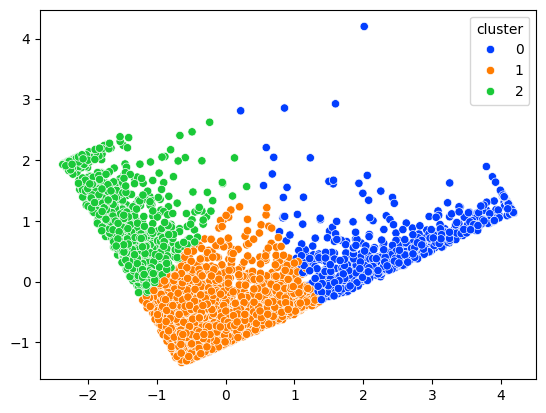

In [60]:
# Cluster visualization in 2D

pca_2d = PCA(n_components=2)
pca_2d.fit(rfm_scaled)

rfm_scaled_pca_2d = pca_2d.fit_transform(rfm_scaled)

# menampilkan visualisasi
sns.scatterplot(x=rfm_scaled_pca_2d[:,0], y=rfm_scaled_pca_2d[:,1], hue=rfm['cluster'], palette='bright');

### B. Clustering Distribution

In [61]:
# menghitung jumlah data dalam setiap 'cluster'
rfm['cluster'].value_counts()

cluster
1    2562
2    1046
0     731
Name: count, dtype: int64

> Mayoritas customer berada pada Cluster 1 (2562), diikuti oleh Cluster 2 (1046), dan Cluster dengan jumlah customer paling rendah adalah Cluster 0 (731)

### C. Means of Features

In [62]:
# menghitung nilai rata-rata dari RFM
rfm_kmeans = rfm.groupby('cluster').mean()

# menampilkan data
rfm_kmeans

,recency,frequency,monetary_value
cluster,,,
0,26.445964,228.461012,4073.089509
1,47.030835,53.169399,877.973986
2,248.129063,23.374761,399.507361


### D. Summary Heatmap

<Axes: ylabel='cluster'>

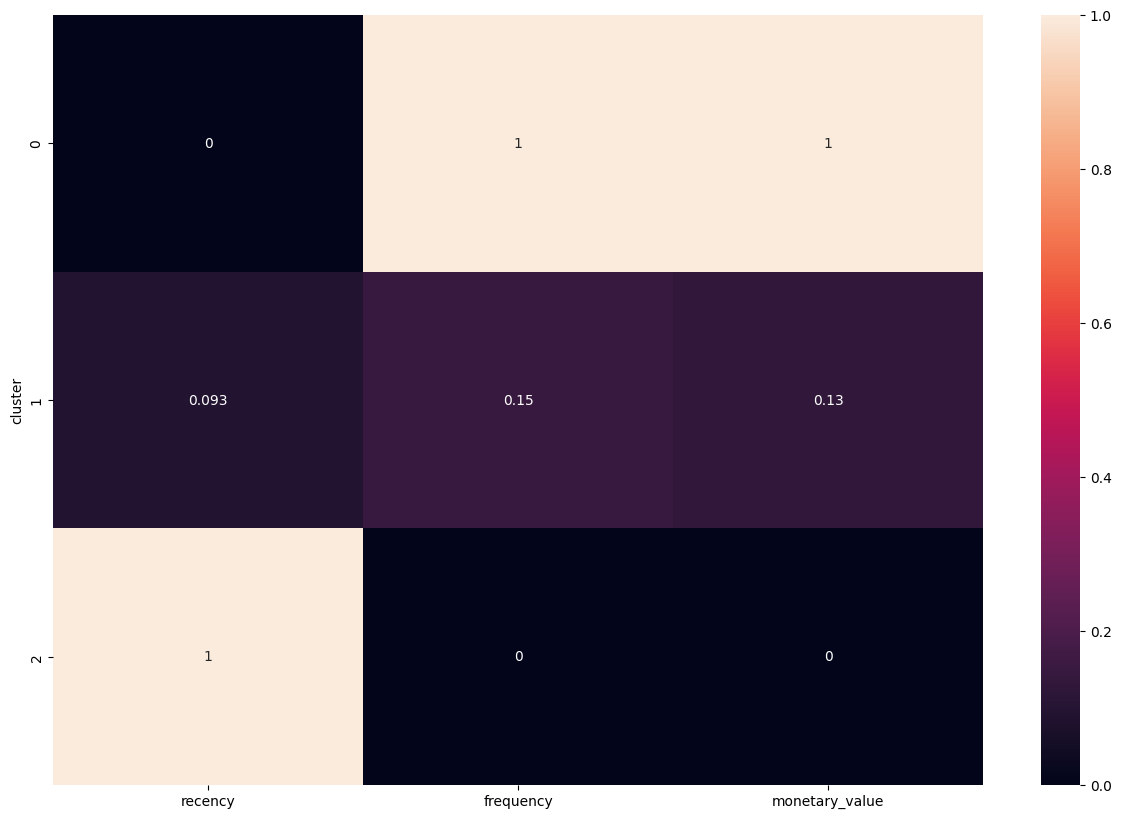

In [63]:
# scalling pada data
scaler = MinMaxScaler()
data = scaler.fit_transform(rfm_kmeans)
scaled_kmeans = pd.DataFrame(data,rfm_kmeans.index,rfm_kmeans.columns)

# menampilkan visualisasi
plt.figure(figsize=(15,10))
sns.heatmap(scaled_kmeans,annot=True)

> Jika dilihat dari heatmap diatas, dapat disimpulkan bahwa sudah ada 3 segmentasi, cluster 1 dengan nilai rfm terbaik menjadi customer terbaik, cluster 2 adalah customer baru/menengah, sedangkan cluster 3 berisi customer yang beresiko hilang.

### E. Cluster Feature Variance

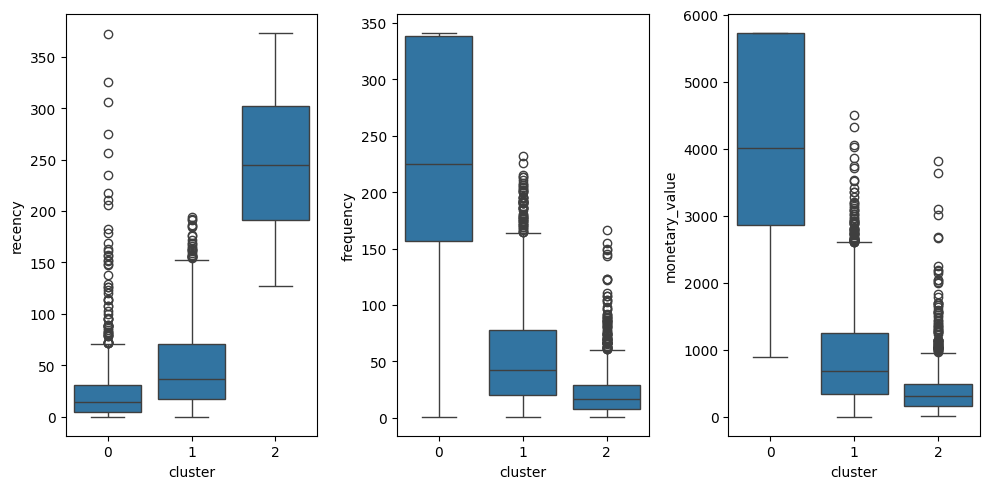

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(10,5))
axes = axes.flatten()

for ax, col in zip(axes, rfm):
    plot = sns.boxplot(x=rfm["cluster"], y=rfm[col], ax=ax)
    plt.tight_layout()

## 6.6 Clustering Conclusion

1. **Cluster 0: Loyal High Spenders**
   - **Recency**: Secara rata-rata, pelanggan dalam Cluster ini baru-baru ini melakukan pembelian (26 hari yang lalu).
   - **Frequency**: Mereka cukup sering melakukan pembelian (rata-rata sebanyak 228 kali).
   - **Monetary Value**: Pelanggan-pelanggan ini memiliki pengeluaran tertinggi (rata-rata sebesar 4073).

   Cluster ini mewakili pelanggan-pelanggan yang paling berharga, yang berbelanja dengan sering dan mengeluarkan uang paling banyak. Strategi untuk mempertahankan pelanggan-pelanggan ini dan mendorong mereka untuk melanjutkan kebiasaan berbelanja mereka bisa sangat bermanfaat.

2. **Cluster 1: New Enthusiasts**
   - **Recency**: Pelanggan baru-baru ini melakukan pembelian (rata-rata 47 hari yang lalu).
   - **Frequency**: Mereka melakukan pembelian dengan frekuensi sedang (rata-rata sebanyak 53 kali).
   - **Monetary Value**: Mereka mengeluarkan jumlah uang sedang (rata-rata sebesar 878).

   Cluster ini mungkin mewakili pelanggan-pelanggan baru yang mulai berbelanja. Mereka tidak mengeluarkan uang sebanyak pelanggan-pelanggan di Cluster 0, tetapi menunjukkan potensi. Kampanye pemasaran yang disesuaikan dan penawaran khusus bisa mendorong mereka untuk meningkatkan frekuensi dan nilai pembelian mereka.

3. **Cluster 2: At-Risk Low Spenders**
   - **Recency**: Pelanggan dalam grup ini belum melakukan pembelian baru-baru ini (rata-rata 248 hari yang lalu).
   - **Frequency**: Mereka tidak berbelanja sangat sering (rata-rata sebanyak 23 kali).
   - **Monetary Value**: Mereka mengeluarkan jumlah uang paling sedikit (rata-rata sebesar 399).

   Pelanggan-pelanggan ini berisiko berhenti berbelanja karena mereka tidak melakukan pembelian baru-baru ini, tidak berbelanja secara sering, dan mengeluarkan uang sedikit. Strategi retargeting, kampanye re-engagement,bisa mengaktifkan kembali pelanggan-pelanggan ini.

### Business Insight:

- **Customer Retention**: Fokus untuk mempertahankan loyalitas pelanggan Cluster 0 dengan menyediakan layanan VIP, loyalty programs, atau personalized offers.
- **Growth Potential**: Dorong pelanggan Cluster 1 untuk menjadi Cluster 0 dengan menawarkan insentif yang membalas peningkatan frekuensi dan nilai pembelian.
- **Customer Reactivation**: Untuk Cluster 2, lakukan win back campaigns, special offers, atau survei untuk memahami ketidakaktifan mereka dan mengatasi masalah tersebut.
- **Personalization**: Gunakan wawasan dari setiap Cluster untuk menyesuaikan komunikasi, penawaran, dan rekomendasi untuk lebih memenuhi kebutuhan dan preferensi setiap kelompok.

Dengan menerapkan strategi yang ditargetkan untuk setiap Cluster, bisnis ini dapat fokus untuk meningkatkan overall customer lifetime value dan mengurangi churn rate.
    